# Additional Examples
In the following section more examples for using pytalises will be explored

In [1]:
import pytalises as pt
import numpy as np
from matplotlib import pyplot as plt

## Time-dependent Rabi model
In [Usage and Examples](examples.ipynb) the time-independent Rabi model was already simulated. The independence from $t$ is achieved by going into a rotating frame. Here we look at the regular Schrödinger picture of the Hamiltonian.

The system comprises of two internal states that differ in their energy by $\hbar\omega$.
An interaction is driven by a periodic potential. The complete potential is

$$
V/\hbar
=
\begin{bmatrix}
0 & \frac{\Omega}{2}\exp (i\omega t) \\
\frac{\Omega}{2}\exp (-i\omega t) & \omega
\end{bmatrix}
$$


where $\Omega$ is the Rabi frequency.

In [2]:
psi = pt.Wavefunction(["exp(-x**2)","0"], number_of_grid_points=(256,),
    spatial_ext=(-5,5), normalize_const=1.0)

v = ["0", "Omega_Rabi/2*exp(-1j*omega*t)", "omega"]

f_Rabi = 1
Omega_Rabi = 2*np.pi*f_Rabi
pulse_length = 1/f_Rabi # One complete inversion
num_time_steps = 100
pop = np.zeros((num_time_steps, 2)) # vector that saves state
time = np.zeros(num_time_steps)

We simulate the time-propagation for one time unit. Since the Rabi frequency is $2\pi$ we will achieve exactly one inversion.

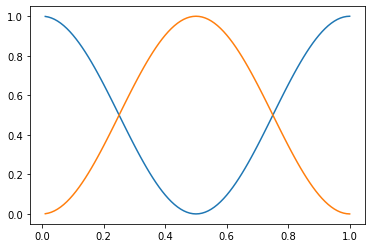

In [3]:
for i in range(num_time_steps):
    psi.propagate(v, num_time_steps=1,
        delta_t=pulse_length/num_time_steps,
        variables={'Omega_Rabi': Omega_Rabi, 'omega': 10})
    pop[i,:] = psi.state_occupation()
    time[i] = psi.t

plt.plot(time, pop)

## Excitation with momentum transfer
One can also achieve excitation with momentum transfer $|p\rangle \leftrightarrow |p+k\rangle$ with periodic potentials with spatial periodicity $k$. Ultimately this is what happens with monochromatic laser light that is $\propto \exp i(kx-\omega t)$.
Let us look a that in a concrete example:


> **Note**: In many examples we set $\hbar=m$. Thus, the Schrödinger equation svoled is $\partial_t \psi = \frac{1}{2}\nabla^2 \psi + \frac{V}{\hbar} \psi$. Furthermore this implies that in these simulations velocity and wave vector are the same $v = \frac{p}{m} = \frac{\hbar k}{m} = k$. The numeric value for the mass of the simulated particle can be changed with the keyword argument `m` in the `pytalises.Wavefunction` class.

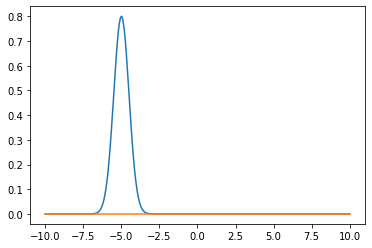

In [4]:
psi = pt.Wavefunction(["exp(-(x+5)**2)","0"], number_of_grid_points=(256,),
    spatial_ext=(-10,10), normalize_const=1.0)

plt.plot(psi.r, np.abs(psi.amp)**2)

Again, we have a two levle system. We will excite the ground state to the excited state but this time the excited state will gain momentum.
The potential for a resonant excitation is


$$
V/\hbar
=
\begin{bmatrix}
0 & \frac{\Omega}{2}\exp i((\omega+\frac{k^2}{2} )t + kx) \\
\frac{\Omega}{2}\exp -i((\omega+\frac{k^2}{2} )t + kx) & \omega
\end{bmatrix}
$$


The frequency $\omega$ has to be adjusted in order to drive a resonant excitation. There are two reasons for this. Firstly, the momentum transfer results in an increase in kinetic energy $\frac{p^2}{2}$. Furthermore, the state with gained velocity $v$ experiences a Doppler shift of the potential that decreases the seen frequency by $-v \cdot k$. in Our case the velocity is also $k$ since we start with zero intial velocity. The frequency has to be adjusted by $-(\frac{p^2}{2m\hbar}-v\cdot k) = -(\frac{k^2}{2}-k\cdot k) = \frac{k^2}{2}.$

The pulse will be applied for a quarter the time that it need for an inversion. In this case we achieve a 50:50 superposition of excited and ground state.

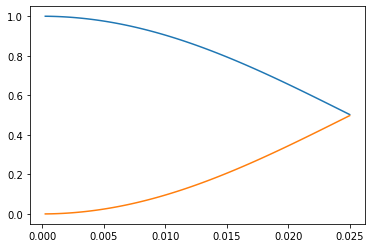

In [5]:
v = ["0", "Omega_Rabi/2*exp(-1j*((omega+k**2/2)*t-k*x))", "omega"]

f_Rabi = 10
Omega_Rabi = 2*np.pi*f_Rabi
pulse_length = 1/f_Rabi/4 # length for 50:50 beamsplitter pulse
num_time_steps = 100
pop = np.zeros((num_time_steps, 2))
time = np.zeros(num_time_steps)

for i in range(num_time_steps):
    psi.propagate(v, num_time_steps=1,
        delta_t=pulse_length/num_time_steps,
        variables={'Omega_Rabi': Omega_Rabi, 'omega': 10, 'k':10})
    pop[i,:] = psi.state_occupation()
    time[i] = psi.t

plt.plot(time, pop)

Indeed, we achieve an equal superposition. Lets have a look at our wave function in momentum space:

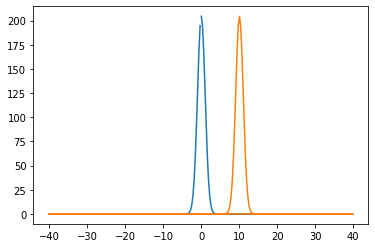

In [6]:
psi.fft()
plt.plot(psi.k, np.abs(psi.amp)**2)

Also in momentum space we have an equal superposition of the states $|p\rangle$ and $|p+k\rangle=|p+10\rangle$.
Wec can also see that looking at the simple free propagation in position space:

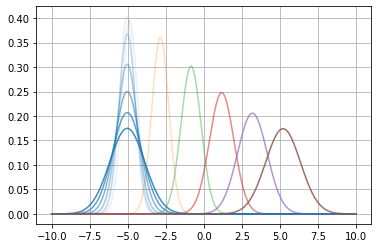

In [7]:
psi.ifft() # transform back into r-space
for i in range(6):
    plt.plot(psi.r, np.abs(psi.amp[:,0])**2, 'C0-', alpha=.1+i*.15)
    plt.plot(psi.r, np.abs(psi.amp[:,1])**2, '', alpha=.1+i*.15)
    plt.grid(True)
    psi.freely_propagate(num_time_steps=1, delta_t=0.2)

# Three-level Raman transitions
In this section we derive the standard three-level Hamiltonian for Raman transitions and simulate the transition.
First we do this with no spatial dependency on the electro-magnetic field (and therefore no momentum transfer) and then extend this model to the physically relevant situation of imparting a large momentum via two-photon transition on the wave-packet.
## Raman transitions with no momentum transfer
The general aim of a Raman transition is to transfer probability amplitudes between two states via a third intermediate state.
In this example the three states are $|\omega_g\rangle$, $|\omega_e\rangle$ and $|\omega_i\rangle$. The ground and excited state will be coupled to the intermediate state with monochromatic light of frequencies $\omega_1$ and $\omega_2$, but no direct coupling between the excited and ground state is present.

![Three-level Raman transition](static/raman_no_momentum.svg)

$\Delta$ is the so called one-photon detuning.
The Hamiltonian can be written as follow:

In [8]:
from sympy import *
x, t = symbols('x t', real=True)
Omega_1, Omega_2 = symbols('\Omega_1 \Omega_2', real=True)
k_1, k_2 = symbols('k_1 k_2', real=True)
omega_1, omega_2 = symbols('\omega_1 \omega_2', real=True)
omega_g, omega_e, omega_i = symbols('\omega_g \omega_e \omega_i', real=True)
hbar = symbols('\hbar', constant=True)

H02 = Omega_1/2*exp(I*(k_1*x-omega_1*t))
H12 = Omega_1/2*exp(I*(k_1*x-omega_2*t))
H = Matrix([
        [omega_g,   0,      conjugate(H02)],
        [0,     omega_e,    conjugate(H12)],
        [H02,   H12,        omega_i]])
H

Matrix([
[                               \omega_g,                                       0, \Omega_1*exp(-I*(-\omega_1*t + k_1*x))/2],
[                                      0,                                \omega_e, \Omega_1*exp(-I*(-\omega_2*t + k_1*x))/2],
[\Omega_1*exp(I*(-\omega_1*t + k_1*x))/2, \Omega_1*exp(I*(-\omega_2*t + k_1*x))/2,                                 \omega_i]])

However, there is one problem in using this Hamiltonian for simulations: the frequency differences between the internal states (e.g. $\omega_i-\omega_g$) for optical transitions are at least in the order of $10^{12}\mathrm{Hz}$. Thus, for simulations with high numerical accuracy, one would need a very short step size in the time domain. In order to relax this we will transform the Hamiltonian into a rotating frame in which the high frequency components will be removed.  
The high frequency components of the wave function in the Schrödinger picture are removed by multiplying it with the transformation matrix $\Psi_I = R\Psi$.
The Hamiltonian describing the same dynamics is then $H_I = R H R^\dagger - i R \dot{R^\dagger} $.
We choose the frequencies of the rotating frame to be

In [9]:
R = Matrix([
    [exp(I*(omega_i-omega_1)*t),  0,                                0],
    [0,                 exp(I*(omega_i-omega_2)*t),                 0],
    [0,                 0,                          exp(I*omega_i*t)]
    ])
R

Matrix([
[exp(I*t*(-\omega_1 + \omega_i)),                               0,                 0],
[                              0, exp(I*t*(-\omega_2 + \omega_i)),                 0],
[                              0,                               0, exp(I*\omega_i*t)]])

$R$ can be somewhat arbitrarily chosen. This choice will yield a Hamitlonian only dependent on $\Delta$.
Let us perform the transformation:

In [10]:
H_I = R*H*conjugate(R) - I*R*conjugate(diff(R,t))
simplify(H_I)

Matrix([
[\omega_1 + \omega_g - \omega_i,                              0, \Omega_1*exp(-I*k_1*x)/2],
[                             0, \omega_2 + \omega_e - \omega_i, \Omega_1*exp(-I*k_1*x)/2],
[       \Omega_1*exp(I*k_1*x)/2,        \Omega_1*exp(I*k_1*x)/2,                        0]])

The time-dependencies on the nondiagonal elements have completely vanished. Looking at the above sketch of the three-level system we see that the diagonal elements are $\omega_1+\omega_g-\omega_o=-\Delta$, $\omega_2+\omega_e-\omega_i=-\Delta$ and $0$.  
This is the potential we will use for the first simulation.


$$
V = 
\begin{bmatrix}
-\Delta & 0 & \frac{\Omega_1}{2} \\
0 &-\Delta & \frac{\Omega_2}{2} \\
\frac{\Omega_1}{2} & \frac{\Omega_2}{2} & 0
\end{bmatrix}
$$


For now we will also neglect the spatial dependencies on $k_1$ and $k_2$. We will look at them in the next example when we simulate the transition with momentum transfer.  
Furthermore we actually use SI units from now on and simulate these Hamitlonian on a real world example: the Rubidium-87 D$_2$-line transitions.
The intermediate state will be one of the 5$^2$P$_{3/2}$ states. The ground and excited states are the 5$^2$S$_{1/2}$ $F=1$ and $F=2$ states.

In [17]:
m = 1.4447e-25 # Mass of a Rubidium atom

psi = pt.Wavefunction(["exp(-((x-x0)/(2*sigma_x))**2)","0","0"],
    number_of_grid_points=(256,), spatial_ext=(-10e-6,10e-6),
    normalize_const=1.0, m=m,
    variables={'x0': 0, 'sigma_x': 3e-6})

# List of strings describing the lower triangular part of V
V = ["-Delta", "0", "Omega/2", "-Delta", "Omega/2", "0"]

# omega_i-omega_g: energy difference between F'=3 and F=2 Rubidium-87 D2-lines
omega_ig    = 2*np.pi*384.230484468e12 
# omega_e-omega_g: energy difference betwwen F=2 and F=1 of the 5^2 S_{1/2} manifold
omega_eg    = 2*np.pi*6.8e9
# One-photon detuning of 700 MHz
Delta       = 2*np.pi*700e6

The general Rabi frequency for such two-photon transitions is different from the Rabi frequency of the single-photon transitions. It is $\Omega = \frac{\Omega_1 \Omega_2}{2\Delta}$. We calculate the single-photon Rabi frequencies $\Omega_i$ from the fact that we aim to achieve Rabi cycles of the two-photon transition of length $100\; \mathrm{ms}$.

[4.99996169e-01 4.99968120e-01 3.57117348e-05]


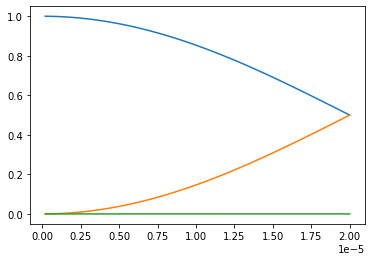

In [16]:
f_Rabi          = 1/100e-6
Omega           = np.sqrt(2*2*np.pi*f_Rabi * Delta)

pulse_length    = 1/f_Rabi/4 # length for beamsplitter
num_time_steps  = 100
pop = np.zeros((num_time_steps, 3))
time = np.zeros(num_time_steps)

for i in range(num_time_steps):
    psi.propagate(V, num_time_steps=1,
        delta_t=pulse_length/num_time_steps,
        variables={'Omega': Omega, 'Delta': Delta})
    pop[i,:] = psi.state_occupation()
    time[i] = psi.t
plt.plot(time, pop[:,:])

After $25\;\mathrm{ms}$ an equal superposition of ground and excited states is achieved. The intermediate state is only very sparsely populated, but the probability amplitude is indeed transfered via the intermediate state as no nondiagonal elements between ground and excited state exist.

## with momentum

[5.00093607e-01 4.99879518e-01 2.68746302e-05]


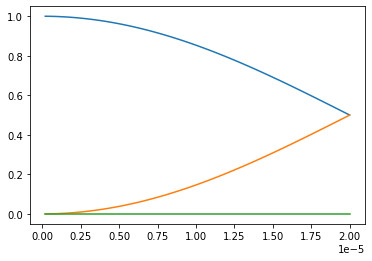

In [12]:
from scipy.optimize import root
m = 1.4447e-25
hbar = 1.0545718e-34
c = 299792458

psi = pt.Wavefunction(["exp(-((x-x0)/(2*sigma_x))**2)","0","0"],
    number_of_grid_points=(512,), spatial_ext=(-20e-6,20e-6),
    normalize_const=1.0, m=m,
    variables={'x0': 0, 'sigma_x': 3e-6})

V = ["-Delta", "0", "Omega_Rabi/2*exp(1j*k_1*x)", "-(Delta+delta)", "Omega_Rabi/2*exp(1j*k_2*x)", "0"]

vel = 0
omega_ig    = 2*np.pi*384.230484468e12
omega_eg    = 2*np.pi*6.8e9
Delta       = 2*np.pi*700e6
f_Rabi      = 1/80e-6
Omega_Rabi  = np.sqrt(2*2*np.pi*f_Rabi * Delta)
omega_1     = omega_ig-Delta
k_1         = omega_1/c
k_2         = root(lambda k_2: hbar/2/m*(k_1-k_2)**2 + (k_1-k_2)*vel - (omega_1 - c*np.abs(k_2)) + omega_eg, -k_1).x
omega_2     = c*np.abs(k_2)
delta    = omega_1-omega_2-omega_eg
#pulse_length = 10/np.sqrt((Omega_Rabi/2/np.pi)**2+(Delta/2/np.pi)**2)/2 # length for 50:50 beamsplitter pulse
pulse_length = 1/f_Rabi/4 # length for 50:50 beamsplitter pulse
num_time_steps = 100
pop = np.zeros((num_time_steps, 3))
time = np.zeros(num_time_steps)

for i in range(num_time_steps):
    psi.propagate(V, num_time_steps=1,
        delta_t=pulse_length/num_time_steps,
        variables={'Omega_Rabi': Omega_Rabi, 'c': c, 'vel': vel,
        'omega_1': omega_1, 'k_1': k_1, 'omega_2': omega_2, 'k_2': k_2,
        'Delta': Delta, 'delta': delta})
    pop[i,:] = psi.state_occupation()
    time[i] = psi.t
print(pop[-1])
plt.plot(time, pop[:,:])

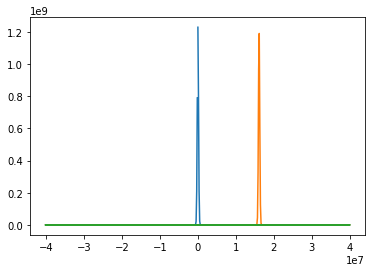

In [13]:
psi.fft()
plt.plot(psi.k, np.abs(psi.amp)**2)

# Bragg

[9.99999656e-01 3.43908496e-07]


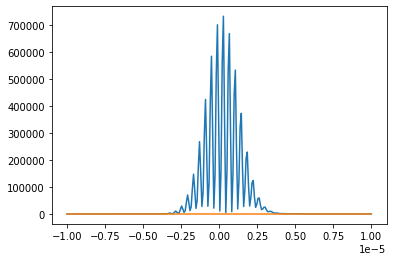

In [14]:
from scipy.optimize import root
m = 1.4447e-25
hbar = 1.0545718e-34
c = 299792458

psi = pt.Wavefunction(["exp(-((x-x0)/(2*sigma_x))**2)","0"],
    number_of_grid_points=(256,), spatial_ext=(-10e-6,10e-6),
    normalize_const=1.0, m=m,
    variables={'x0': 0, 'sigma_x': 1e-6})

V = ["-Delta", "Omega_Rabi/2 * (1/sqrt(1)*exp(1j*k_1*(x+v*t))+1/sqrt(1)*exp(1j*(k_2*(x+v*t)+delta*t)))", "0"]

v = 0
omega_ig    = 2*np.pi*384.230484468e12
Delta       = 2*np.pi*700e6
f_Rabi      = 1/500e-6
Omega_Rabi  = np.sqrt(2*2*np.pi*f_Rabi * Delta)
omega_1     = omega_ig-Delta
k_1         = omega_1/c
k_2         = root(lambda k_2: hbar/2/m*(k_1-k_2)**2 + (k_1-k_2)*v - (omega_1 - c*np.abs(k_2)) , -k_1).x
omega_2     = c*np.abs(k_2)
delta       = omega_1-omega_2
pulse_length = 1/f_Rabi/4 # length for 50:50 beamsplitter pulse
num_time_steps = 100
pop = np.zeros((num_time_steps, 2))
time = np.zeros(num_time_steps)

for i in range(num_time_steps):
    psi.propagate(V, num_time_steps=1,
        delta_t=pulse_length/num_time_steps,
        variables={'Omega_Rabi': Omega_Rabi, 'c': c, 'v': v,
        'omega_1': omega_1, 'k_1': k_1, 'omega_2': omega_2, 'k_2': k_2,
        'Delta': Delta, 'delta': delta})
    pop[i,:] = psi.state_occupation()
    time[i] = psi.t
print(pop[-1])
#plt.plot(time, pop[:,:])
plt.plot(psi.r, np.abs(psi.amp)**2)

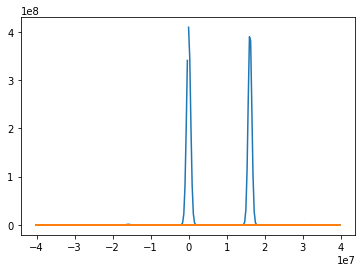

In [15]:
psi.fft()
plt.plot(psi.k, np.abs(psi.amp)**2)